In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

2025-04-12 17:30:41.473450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744479041.692278      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744479041.754499      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/normalcsv/dataset_labels.csv")
print(df.head())

                                          image_path          label
0              Biodegradable/leaf_waste/00000042.jpg  Biodegradable
1              Biodegradable/leaf_waste/00000080.jpg  Biodegradable
2              Biodegradable/leaf_waste/00000113.jpg  Biodegradable
3  Biodegradable/leaf_waste/a6876e29-dc0f-4716-bd...  Biodegradable
4              Biodegradable/leaf_waste/00000115.jpg  Biodegradable


In [3]:
dff=pd.DataFrame(df)
dff.tail()

,image_path,label
31069,Recyclable/paper_cups/Image_60.png,Recyclable
31070,Recyclable/paper_cups/Image_132.png,Recyclable
31071,Recyclable/paper_cups/Image_4 (2).png,Recyclable
31072,Recyclable/paper_cups/Image_165.png,Recyclable
31073,Recyclable/paper_cups/Image_27 (2).png,Recyclable


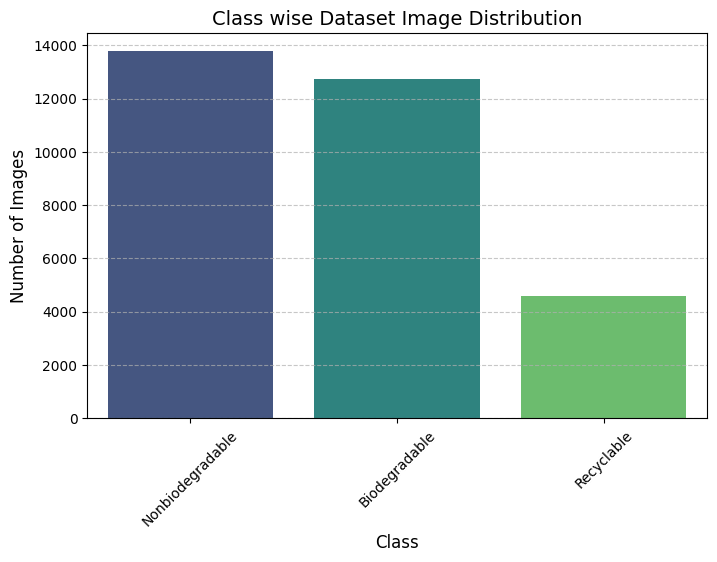

In [4]:
# Load dataset labels CSV
csv_path = "/kaggle/input/normalcsv/dataset_labels.csv"  
df = pd.read_csv(csv_path)

# Count images per class
class_counts = df["label"].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Add labels
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class wise Dataset Image Distribution", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [5]:
df = pd.read_csv("/kaggle/input/normalcsv/dataset_labels.csv")
print(df["label"].value_counts()) 

label
Nonbiodegradable    13774
Biodegradable       12728
Recyclable           4572
Name: count, dtype: int64


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
from PIL import ImageFile
import os

# Fix for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "/kaggle/input/dataset/DATASET"

# Data Preprocessing & Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="training",
    shuffle=True
)

val_ds = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    subset="validation",
    shuffle=False
)

# Compute class weights
y_train = train_ds.classes
weights_array = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = tf.constant(weights_array, dtype=tf.float32)
print("Class Weights:", weights_array)


Found 26294 images belonging to 3 classes.
Found 6571 images belonging to 3 classes.
Class Weights: [0.75453398 0.7953418  2.39602697]


I0000 00:00:1744479132.188797      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744479132.189434      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
# Custom loss function: Sparse Weighted Cross-Entropy
def sparse_weighted_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    weights = tf.gather(class_weights_tensor, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weights

# Base model: ResNet50
base_model = ResNet50(
    weights='/kaggle/input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop (1).h5',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True

# Fine-tuning: Unfreeze last few layers
fine_tune_at = len(base_model.layers) - 10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(train_ds.class_indices), activation='softmax')(x)

# Final model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sparse_weighted_crossentropy,
    metrics=["accuracy"]
)

# Model checkpoint callback
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max"
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

# Load and evaluate the best model
best_model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",
    custom_objects={"sparse_weighted_crossentropy": sparse_weighted_crossentropy}
)

loss, acc = best_model.evaluate(val_ds)
print(f"Best Validation Accuracy after Fine-Tuning: {acc * 100:.2f}%")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744480088.398594     108 service.cc:148] XLA service 0x7de388004840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744480088.403866     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744480088.403888     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744480089.977136     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/822 ━━━━━━━━━━━━━━━━━━━━ 6:01:14 26s/step - accuracy: 0.3750 - loss: 1.3722

I0000 00:00:1744480098.095231     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 48/822 ━━━━━━━━━━━━━━━━━━━━ 7:18 566ms/step - accuracy: 0.3852 - loss: 1.2317

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


822/822 ━━━━━━━━━━━━━━━━━━━━ 626s 730ms/step - accuracy: 0.5772 - loss: 0.9297 - val_accuracy: 0.3117 - val_loss: 1.2573
Epoch 2/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 424s 513ms/step - accuracy: 0.6851 - loss: 0.7510 - val_accuracy: 0.5270 - val_loss: 1.1275
Epoch 3/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 422s 509ms/step - accuracy: 0.6991 - loss: 0.7230 - val_accuracy: 0.4614 - val_loss: 1.3241
Epoch 4/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 420s 507ms/step - accuracy: 0.7137 - loss: 0.7014 - val_accuracy: 0.4885 - val_loss: 1.2045
Epoch 5/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 423s 512ms/step - accuracy: 0.7030 - loss: 0.7042 - val_accuracy: 0.3890 - val_loss: 1.9481
Epoch 6/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 422s 510ms/step - accuracy: 0.7177 - loss: 0.6870 - val_accuracy: 0.4667 - val_loss: 1.0963
Epoch 7/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 418s 504ms/step - accuracy: 0.7241 - loss: 0.6741 - val_accuracy: 0.5404 - val_loss: 0.9928
Epoch 8/20
822/822 ━━━━━━━━━━━━━━━━━━━━ 422s 510ms/step - accuracy: 0.7213 - loss: 0.67

In [11]:
val_acc_history = history.history['val_accuracy']

best_epoch_index = np.argmax(val_acc_history)
best_val_acc = val_acc_history[best_epoch_index]

print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Validation Accuracy: 58.64%


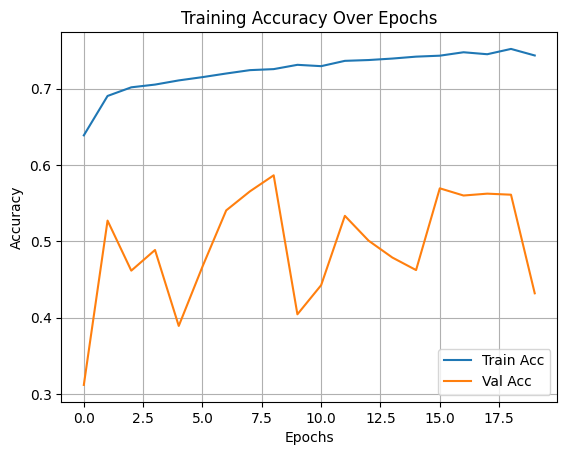

In [12]:
# Plot training results
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


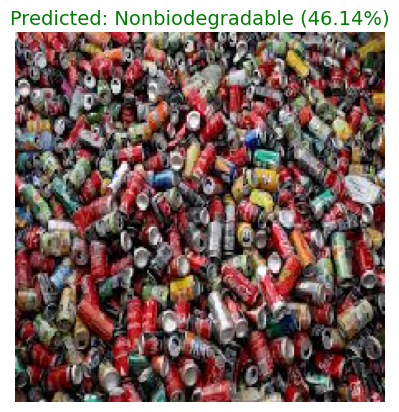

In [14]:
from tensorflow.keras.preprocessing import image
class_labels = ['Biodegradable', 'Nonbiodegradable', 'Recyclable']

# Load your best model (important!)
model = tf.keras.models.load_model(
    "/kaggle/working/best_model.keras",
    custom_objects={"sparse_weighted_crossentropy": sparse_weighted_crossentropy}
)

def predict_and_plot(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_expanded)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_labels[predicted_class]

    # Show the image and prediction
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=14, color='green')
    plt.show()

# Example usage
img_path = "/kaggle/input/testing/cens.jpg"  
predict_and_plot(img_path)
